In [ ]:
!pip install transformers
!pip install torch torchvision torchaudio
!pip install wordcloud
!pip install tensorflow

In [4]:
from transformers import pipeline
import torch
import tensorflow as tf
import torch.nn.functional as F
import os
import tarfile
import boto3
from sagemaker import get_execution_role
from sagemaker.huggingface import HuggingFaceModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from keras import backend as K
from tensorflow.python.saved_model import builder as bld
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.models import load_model
import pickle
from sagemaker.tensorflow.model import TensorFlowModel
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import numpy as np
from tqdm import tqdm
from wordcloud import WordCloud

2025-05-01 10:12:07.503701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746094327.526026    7213 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746094327.532583    7213 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746094327.550107    7213 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746094327.550137    7213 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746094327.550139    7213 computation_placer.cc:177] computation placer alr

[05/01/25 10:13:09] INFO     Found credentials from IAM Role:                                   ]8;id=772530;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=473490;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## getting Dataset from S3 bucket

In [5]:
role = get_execution_role()

s3 = boto3.client("s3")
bucket_name = "posthere0101"
key = "datasets/cleaned_reviews.csv"

dataset = s3.get_object(Bucket = bucket_name , Key = key)
df = pd.read_csv(dataset["Body"])
df.head(10)

[05/01/25 10:13:13] INFO     Found credentials from IAM Role:                                   ]8;id=708517;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=407883;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[05/01/25 10:13:14] INFO     Found credentials from IAM Role:                                   ]8;id=817788;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=626363;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64

In [7]:
df2 = df.copy()
df2["sentiments"] = df2["sentiments"].map({"negative":0 , "neutral":0 ,"positive":1})
df2["sentiments"].value_counts()

sentiments
1    9503
0    7834
Name: count, dtype: int64

[04/28/25 09:01:53] INFO     Using categorical units to plot a list of strings that are all         ]8;id=131350;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=211313;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=76943;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=491395;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

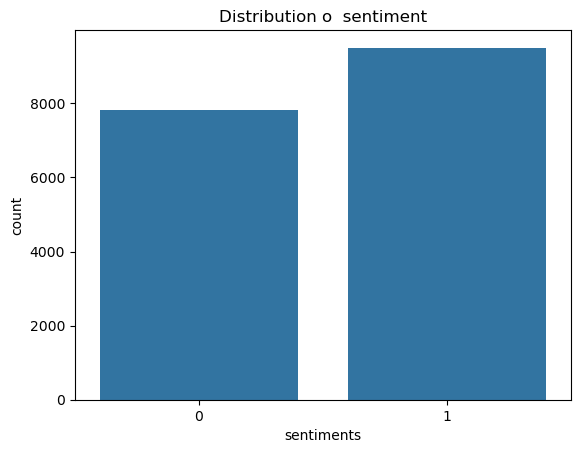

In [27]:
value_counts = df2["sentiments"].value_counts()
sns.barplot(x = value_counts.index , y = value_counts.values)
plt.xlabel("sentiments")
plt.ylabel("count")
plt.title("Distribution ofb  sentiment")
plt.show()

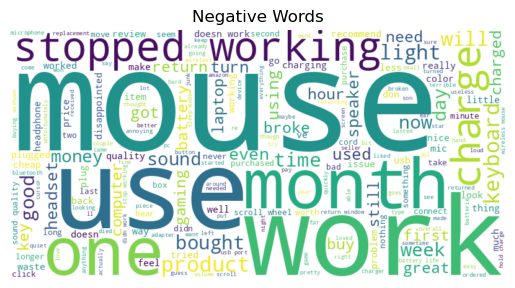

In [33]:
negative_words = " ".join(df2[df2["sentiments"]==0]["cleaned_review"].astype(str))
wordcloud = WordCloud(width=800 , height=400, background_color="white").generate(negative_words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Words")
plt.show()

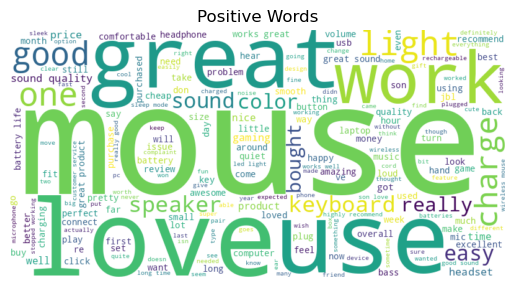

In [32]:
positive_words = ' '.join(df2[df2['sentiments'] == 1]['cleaned_review'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

In [8]:
texts = np.array(df2["cleaned_review"])
labels = np.array(df2["sentiments"])

## Creating Classifier Pipeline using Transformer Library

In [9]:
classifier = pipeline("text-classification", model="MarieAngeA13/Sentiment-Analysis-BERT")

config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [10]:
classifier("this is bad")[0]["label"]

'negative'

## Checking if there is any values other than str

In [11]:
for text in texts:
    if not isinstance(text , str):
        print(text)

## Prediction Process

In [ ]:
predicted_labels = []
sentiment_mapping = {"negative":0 , "neutral":0 ,"positive":1}
for text in tqdm(range(len(texts))):
    prediction = classifier(texts[text][:512])[0]["label"]
    predicted_labels.append(sentiment_mapping[prediction])

predicted_labels = np.array(predicted_labels)

## Storing the Predicted CSV file inside S3 bucket

In [ ]:
pred_df = pd.DataFrame(predicted_labels)
csv_buffer = io.StringIO()
pred_df.to_csv(csv_buffer , index = False)
s3.put_object(Bucket = bucket_name , Key = "datasets/predicted_labels.csv" , Body = csv_buffer.getvalue())

## Getting back the Predicted Csv file from S3 bucket

In [14]:
response = s3.get_object(Bucket = bucket_name , Key = "datasets/predicted_labels.csv")
pred_df = pd.read_csv(response["Body"])
pred_df.head(10)

,Unnamed: 0,0
0,0,1
1,1,0
2,2,0
3,3,0
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [15]:
pred_df.columns = ["id" , "labels"]
pred_df.head(10)

,id,labels
0,0,1
1,1,0
2,2,0
3,3,0
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [16]:
pred_labels = pred_df["labels"].values
pred_labels

array([1, 0, 0, ..., 0, 1, 0])

In [17]:
print(len(labels) , len(pred_labels))

17337 17337


## Accuracy

In [34]:
accuracy = accuracy_score(labels , pred_labels)
print(f"accuracy:{accuracy}")

accuracy:0.8200380688700467


## Classification Report

In [22]:
report = classification_report(labels , pred_labels)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7834
           1       0.83      0.84      0.84      9503

    accuracy                           0.82     17337
   macro avg       0.82      0.82      0.82     17337
weighted avg       0.82      0.82      0.82     17337



## Confusion Matrix

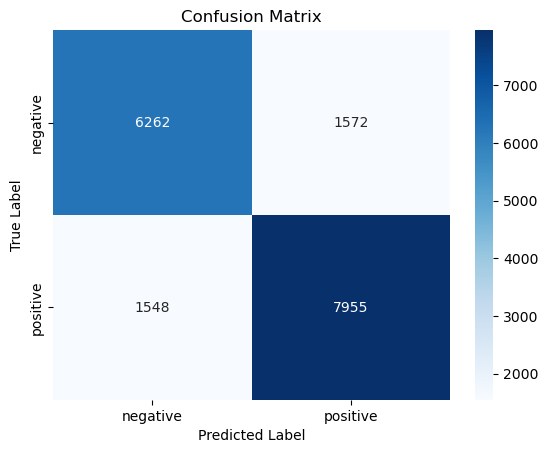

In [25]:
cm = confusion_matrix(labels , pred_labels)
class_name = ["negative" , "positive"]

sns.heatmap(cm , annot = True, fmt = 'd' , cmap = 'Blues' , xticklabels=class_name , yticklabels = class_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Deployment of the model

In [6]:
hub = {
'HF_MODEL_ID':'MarieAngeA13/Sentiment-Analysis-BERT',
'HF_TASK':'text-classification'
}

huggingface_model = HuggingFaceModel(
transformers_version='4.37.0',
pytorch_version='2.1.0',
py_version='py310',
env=hub,
role=role, 
)

endpoint_name = "sentiment-analysis-endpoint04"

predictor = huggingface_model.deploy(
initial_instance_count=1, 
instance_type='ml.m5.xlarge',
endpoint_name = endpoint_name
)

[05/01/25 10:13:25] INFO     Creating model with name:                                              ]8;id=253204;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=715356;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             huggingface-pytorch-inference-2025-05-01-10-13-25-189                                 

                    INFO     Creating endpoint-config with name sentiment-analysis-endpoint04       ]8;id=158058;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=448714;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\

                    INFO     Creating endpoint with name sentiment-analysis-endpoint04              ]8;id=576451;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=73688;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

--------!

## Testing Deployment Endpoint

In [7]:
text = "This is a fantastic product!"
result = predictor.predict({"inputs":text})
result = result[0]
print(f"predicted result: {result['label']}")

predicted result: positive
